#Prediction of TED talks ratings 

#### Date:  May 25th, 2015

This notebook is based on Ted_4_Feature testing, feature engineering/selections are done in other notebooks such as Ted_2 (caption) and Ted_5 (other textual data); the raw data is processed in Ted_1. The splitting of training set and final holdout dataset is done in Ted_3

In [163]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline
import requests
from pattern import web
import operator

In [164]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [165]:
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV

In [166]:
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import label_binarize
from unidecode import unidecode
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.base import BaseEstimator,TransformerMixin

In [167]:
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag

##1. Process themes into vector

In [168]:
talks_small = pd.read_json('train2.json')

In [169]:
talks_small.reset_index(drop = True, inplace = True)

In [170]:
talks_small.shape

(1535, 33)

In [171]:
def themes_fun(row):
    # convert the original themes (dict) to list
    themes = []
    for theme in row['themes']:
        themes.append(theme['theme']['name'])
    return themes

In [172]:
themes = []
for i in xrange(talks_small.shape[0]):
    themes.append(themes_fun(talks_small.ix[i,:]))

In [173]:
# get the total themes, used as vocabulary
th_url = 'https://api.ted.com/v1/themes.json?api-key=ynw2u8e4h9sk8c2htp7vutxq&limit=100'
th_res = requests.get(th_url)

In [174]:
vocab_theme = [(x['theme']['name'],x['theme']['id']) for x in th_res.json()['themes']]

In [175]:
vocab_theme = dict(vocab_theme)

In [176]:
vocab_theme = vocab_theme.keys()

In [177]:
vocab_theme = [u'Live Music',u'Celebrating TEDWomen',u'Whipsmart Comedy',u'Listening to Teachers',u'Spectacular Performance',
 u'Ocean Wonders',u'Bold Predictions, Stern Warnings',u'What Makes Us Happy?',u'Media With Meaning',u'Technology, History and Destiny',
 u'How the Mind Works',u'Talks from TED Fellows',u'Medicine Without Borders',u'Hidden Gems',u'War and Peace',
 u'The Rise of Collaboration',u'TED Prize Winners',u"Evolution's Genius",u'Unconventional Explanations',u"What's Next in Tech",
 u'Presentation Innovation',u'Words About Words',u'Numbers at Play',u'Women Reshaping the World',u'Art Unusual',
 u'Not Business as Usual',u'To Boldly Go ...',u'Architectural Inspiration',u'Africa: The Next Chapter',u'TED in 3 Minutes',
 u'Tales of Invention',u'Inspired by Nature',u'Is There a God?',u'Design That Matters',u'Food Matters',u'How We Learn',u'Master Storytellers',
 u'Animals That Amaze',u'The Power of Cities',u'A Greener Future?',u'The Creative Spark',u'Peering into Space',u'Best of the Web',
 u'Rethinking Poverty',u'The Charter for Compassion',u'Might You Live a Great Deal Longer?',u'Mission Blue Voyage']

In [178]:
vocab_theme[1]

u'Celebrating TEDWomen'

In [179]:
talks_small['themes'] = themes

In [180]:
talks_small['themes'] = talks_small['themes'].apply(lambda x: ' '.join(x))

#### The maximum length of all themes is 35 grams, therefore use ngram_range = (2,40)

In [181]:
# shortest themes are of 2 words, longest 7words
Cvtheme = CountVectorizer(vocabulary=vocab_theme,binary = True, analyzer='char',ngram_range=(2,40),lowercase = False)

##2. Convert onespeaker feature into integer 

In [182]:
talks_small['onespeaker'] = (talks_small['onespeaker']==True).astype(int)

##3. Process the label 

In [183]:
labels = pd.read_csv('response5.csv',header =None )

In [184]:
labels.columns = ['id','label']

#### Make a plot of label distribution in the training set

In [185]:
counts = labels.groupby('label')['label'].count()

In [186]:
fractions = counts/counts.sum()

In [187]:
fractions.index = ['persuasive informative','beautiful courageous inspiring','jaw-dropping ingenious fascinating',
                  'ok obnoxious confusing unconvincing long-winded', 'funny']

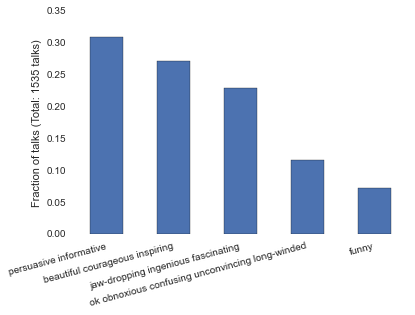

In [188]:
fractions.plot(kind = 'bar')
plt.xticks(rotation = 15, ha = 'right')
plt.ylabel('Fraction of talks (Total: 1535 talks)')

##4. Construct final training set Xdf and y, which is the label 

###4.1 Features from talks_small

In [189]:
Xdf = talks_small[['id','themes','speaker_gender']]

In [190]:
Xdf = Xdf.sort(columns = 'id')

###4.2 Features from captions_f.json, processed in Ted_2 

In [191]:
caps = pd.read_json('captions_f.json')[['id','length','num_para','word_per_sec','laughter_per_word','laugh_as_para',
                                     'applause_total','div_per_word','ithinks','storywords','noun_token','verb_token']]

In [192]:
caps = caps.sort(columns = 'id')

In [193]:
caps.reset_index(inplace = True, drop = True)

### 4.3 Features from processed (title + keywords + description), generated in Ted_5

In [194]:
Xother = pd.read_json('talks_other_text.json')

In [195]:
Xother.sort(columns = 'id',inplace = True)

In [196]:
Xother.reset_index(inplace = True, drop = True)

###4.4 Merge all three sources into Xdf 

In [197]:
Xdf = pd.merge(Xdf,caps,on = 'id')

In [198]:
Xdf = pd.merge(Xdf,Xother, on = 'id')

In [199]:
Xdf.sort(columns = 'id',inplace = True)

###4.5 Generate y from labels 

In [200]:
labels.sort(columns = 'id',inplace = True)

In [201]:
labels.reset_index(drop = True, inplace = True)

In [202]:
y = labels[['label']].values.flatten()

## 5 Learning

### 5.1 a single test-train split 

In [203]:
sss = StratifiedShuffleSplit(y, n_iter = 1, test_size=0.2, random_state=1)

In [204]:
for train_index,test_index in sss:
    Xdftrain,Xdftest = Xdf.ix[train_index,:],Xdf.ix[test_index,:]
    ytrain,ytest = y[train_index],y[test_index]

####5.1.1 Convert the text(title +kw + description) into a matrix using CountVectorizer

In [205]:
Xtrain_text = Xdftrain['text'].as_matrix()

In [206]:
Xtest_text = Xdftest['text'].as_matrix()

##### the following list is derived in Ted_5_NLP_other 

In [207]:
final_text_words = ['global issues', 'science', 'culture', 'new','humor','entertainment']

In [208]:
vect_other = CountVectorizer(vocabulary = final_text_words, stop_words = 'english', ngram_range = (1,2))

In [209]:
Xtrain_text_other = vect_other.fit_transform(Xtrain_text)

In [210]:
Xtest_text_other = vect_other.transform(Xtest_text)

#### 5.1.2 Convert themes into a matrix using Cvtheme (a CountVectorizer) defined previously

In [211]:
Xtrain_th = Cvtheme.fit_transform(Xdftrain.ix[:,'themes'].as_matrix())

In [212]:
Xtest_th = Cvtheme.transform(Xdftest.ix[:,'themes'].as_matrix())

#### 5.1.3 Convert verb and noun tokens in the caption to a matrix using TfidfVectorizer

##### the vocabulary lists are derived in Ted_2_NLP_caption 

In [213]:
vocab_verb_final = [u'like',u'show',u'feel',u'should',u'leave',u'live',u'understand',u'talk',u'ask',u'become',u'change']

In [214]:
vocab_noun_final = [u'life',u'percent',u'question',u'story',u'idea',u'part',u'place',u'fact',u'example',u'problem',u'bit',u'kind',u'today']

In [215]:
tf_noun = TfidfVectorizer(vocabulary = vocab_noun_final,use_idf = False, sublinear_tf = True)

In [216]:
tf_verb = TfidfVectorizer(vocabulary = vocab_verb_final,use_idf = False, sublinear_tf = True)

In [217]:
Xtrain_noun = tf_noun.fit_transform(Xdftrain.ix[:,'noun_token'].as_matrix())

In [218]:
Xtest_noun = tf_noun.transform(Xdftest.ix[:,'noun_token'].as_matrix())

In [219]:
Xtrain_verb = tf_verb.fit_transform(Xdftrain.ix[:,'verb_token'].as_matrix())

In [220]:
Xtest_verb = tf_verb.transform(Xdftest.ix[:,'verb_token'].as_matrix())

#### 5.1.4 Combine all features into Xtrain, Xtest

In [221]:
Xtrain = np.concatenate([Xtrain_th.toarray(),Xtrain_noun.toarray(),Xtrain_verb.toarray(),
                          Xtrain_text_other.toarray(), scale(Xdftrain.ix[:,2:12].as_matrix())],
                         axis = 1)

In [222]:
Xtest = np.concatenate([Xtest_th.toarray(),Xtest_noun.toarray(),Xtest_verb.toarray(),
                         Xtest_text_other.toarray(), scale(Xdftest.ix[:,2:12].as_matrix())],axis = 1)

#### 5.1.5 Test logistic regression, random forest and svm 

#### Logistic Regresion

##### to improve the negative class prediction, class_weight can be specified to 'auto'

In [223]:
clf = LogisticRegression(C = 10, penalty = 'l2',class_weight = 'auto')

In [224]:
clf.fit(Xtrain,ytrain)

LogisticRegression(C=10, class_weight='auto', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [225]:
ytest_pred = clf.predict(Xtest)

In [226]:
print classification_report(ytest,ytest_pred)

             precision    recall  f1-score   support

          0       0.64      0.66      0.65        95
          1       0.67      0.64      0.65        84
          2       0.56      0.55      0.55        71
          3       0.35      0.25      0.29        36
          4       0.52      0.77      0.62        22

avg / total       0.59      0.59      0.59       308



In [227]:
pd.crosstab(ytest_pred,ytest,rownames=['predicted'],colnames = ['true'],margins = True)

true,0,1,2,3,4,All
predicted,,,,,,
0,63,13,12,9,1,98
1,8,54,8,9,2,81
2,15,8,39,7,1,70
3,6,2,8,9,1,26
4,3,7,4,2,17,33
All,95,84,71,36,22,308


In [228]:
(63+ 54+ 39+9+17)/308.

0.5909090909090909

In [229]:
report_precision = [0.52, 0.64, 0.46, 0.47, 0.67]

In [230]:
report_recall = [0.67, 0.62, 0.44, 0.19, 0.64]

In [231]:
report_precision = pd.Series(report_precision, index = fractions.index)

In [232]:
report_recall = pd.Series(report_recall, index = fractions.index)

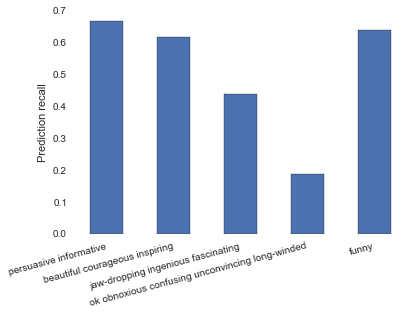

In [233]:
report_recall.plot(kind = 'bar')
plt.xticks(rotation = 15, ha = 'right')
plt.ylabel('Prediction recall')

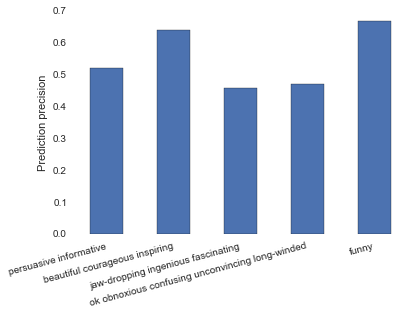

In [72]:
report_precision.plot(kind = 'bar')
plt.xticks(rotation = 15, ha = 'right')
plt.ylabel('Prediction precision')

####SVM 

In [234]:
svm = SVC(class_weight = 'auto',C = 10.0)

In [235]:
svm.fit(Xtrain, ytrain)

SVC(C=10.0, cache_size=200, class_weight='auto', coef0=0.0, degree=3,
  gamma=0.0, kernel='rbf', max_iter=-1, probability=False,
  random_state=None, shrinking=True, tol=0.001, verbose=False)

In [236]:
ytest_pred2 = svm.predict(Xtest)

In [237]:
print classification_report(ytest, ytest_pred2)

             precision    recall  f1-score   support

          0       0.65      0.60      0.62        95
          1       0.68      0.61      0.64        84
          2       0.53      0.55      0.54        71
          3       0.28      0.33      0.30        36
          4       0.52      0.68      0.59        22

avg / total       0.58      0.56      0.57       308



#### random forest

In [238]:
rf = RandomForestClassifier(n_estimators= 300, criterion='gini')

In [239]:
rf.fit(Xtrain,ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [240]:
ytest_pred3 = rf.predict(Xtest)

In [241]:
print classification_report(ytest, ytest_pred3)

             precision    recall  f1-score   support

          0       0.55      0.78      0.64        95
          1       0.58      0.68      0.63        84
          2       0.53      0.49      0.51        71
          3       1.00      0.03      0.05        36
          4       0.88      0.32      0.47        22

avg / total       0.63      0.56      0.53       308



#### generate feature importance list based on rf

In [242]:
other_vocab = sorted(vect_other.vocabulary_.items(), key = operator.itemgetter(1))

In [243]:
other_vocab = [x[0] for x in other_vocab]

In [244]:
noun_vocab = sorted(tf_noun.vocabulary_.items(), key = operator.itemgetter(1))

In [245]:
noun_vocab = [x[0] for x in noun_vocab]

In [246]:
verb_vocab = sorted(tf_verb.vocabulary_.items(), key = operator.itemgetter(1))

In [247]:
verb_vocab = [x[0] for x in verb_vocab]

In [248]:
feature_names = list(vocab_theme) + noun_vocab + verb_vocab + other_vocab + list(Xdftrain.columns[2:12])

In [249]:
feature_importance = pd.Series(rf.feature_importances_,index = feature_names)

In [250]:
feature_importance.sort(ascending = False)

In [251]:
feature_importance

laughter_per_word                      0.046850
word_per_sec                           0.042589
length                                 0.038731
div_per_word                           0.035318
applause_total                         0.034639
num_para                               0.032047
life                                   0.030239
storywords                             0.028145
laugh_as_para                          0.025368
feel                                   0.024585
story                                  0.023602
ithinks                                0.022970
example                                0.022917
show                                   0.022472
talk                                   0.021135
should                                 0.019744
bit                                    0.019308
ask                                    0.019231
percent                                0.018803
fact                                   0.018575
part                                   0

###5.2 Cross-validation on the training set

In [252]:
Xth = Xdf['themes'].as_matrix()

In [253]:
Xth = Cvtheme.fit_transform(Xth)

In [254]:
Xtext_other = vect_other.transform(Xdf['text'].as_matrix())

In [255]:
X_noun = tf_noun.fit_transform(Xdf['noun_token'].as_matrix())

In [256]:
X_verb = tf_verb.fit_transform(Xdf['verb_token'].as_matrix())

In [257]:
X = np.concatenate([Xth.toarray(),X_noun.toarray(), X_verb.toarray(),
                    Xtext_other.toarray(),scale(Xdf.ix[:,2:12].as_matrix())],axis = 1)

In [258]:
score = cross_val_score(clf,X,y,cv = StratifiedKFold(y,n_folds = 5),scoring = 'f1_micro')

In [259]:
print score.mean(),score

0.518079796063 [ 0.49190939  0.50974026  0.47727273  0.55555556  0.55592105]


In [260]:
score2 = cross_val_score(svm,X,y,cv = StratifiedKFold(y,n_folds = 5),scoring = 'f1_micro')

In [261]:
print score2.mean(),score2

0.516765969794 [ 0.47572816  0.49025974  0.51623377  0.55555556  0.54605263]


###Grid search to optimize hyper-parameters for SVM

#### SVM

In [262]:
param_grid_svm = [{'kernel':['rbf'],'C':np.logspace(-2,2,20),'gamma':np.logspace(-3,1,20)}
                  ,{'kernel':['linear'],'C':np.logspace(-2,2,20)}]

In [263]:
svm2 = SVC(class_weight = 'auto')

In [264]:
gs_svm = GridSearchCV(svm2,param_grid_svm,scoring = 'f1_micro',cv = StratifiedKFold(y,n_folds = 5),n_jobs=-1)

In [265]:
gs_svm.fit(X,y)

GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[4 1 ..., 1 2], n_folds=5, shuffle=False, random_state=None),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight='auto', coef0=0.0, degree=3,
  gamma=0.0, kernel='rbf', max_iter=-1, probability=False,
  random_state=None, shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=-1,
       param_grid=[{'kernel': ['rbf'], 'C': array([  1.00000e-02,   1.62378e-02,   2.63665e-02,   4.28133e-02,
         6.95193e-02,   1.12884e-01,   1.83298e-01,   2.97635e-01,
         4.83293e-01,   7.84760e-01,   1.27427e+00,   2.06914e+00,
         3.35982e+00,   5.45559e+00,   8.85867e+00,   1.43845e...   8.85867e+00,   1.43845e+01,
         2.33572e+01,   3.79269e+01,   6.15848e+01,   1.00000e+02])}],
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='f1_micro', verbose=0)

In [266]:
print 'Best score: {:.3f}'.format(gs_svm.best_score_)

Best score: 0.527


In [267]:
print 'Best parameters set:'
best_parameters = gs_svm.best_estimator_.get_params()
for param_name in sorted(param_grid_svm[0].keys()):
    print '\t%s: %r' % (param_name,best_parameters[param_name])

Best parameters set:
	C: 5.4555947811685144
	gamma: 0.029763514416313176
	kernel: 'rbf'


In [268]:
gs_svm.best_estimator_

SVC(C=5.4555947811685144, cache_size=200, class_weight='auto', coef0=0.0,
  degree=3, gamma=0.029763514416313176, kernel='rbf', max_iter=-1,
  probability=False, random_state=None, shrinking=True, tol=0.001,
  verbose=False)

In [269]:
ytrain_pred = gs_svm.predict(X)

In [270]:
print classification_report(y,ytrain_pred)

             precision    recall  f1-score   support

          0       0.74      0.72      0.73       474
          1       0.84      0.76      0.79       418
          2       0.76      0.78      0.77       353
          3       0.62      0.70      0.66       179
          4       0.78      0.97      0.87       111

avg / total       0.76      0.76      0.76      1535



In [271]:
svm_final = gs_svm.best_estimator_

In [272]:
svm_final.support_vectors_.shape

(1350, 87)

###Grid search for Logistic regression 

In [273]:
param_logit = {'C':np.logspace(-2,2,20)}

In [274]:
clf2 = LogisticRegression(class_weight = 'auto',solver = 'lbfgs')

In [275]:
gs_logit = GridSearchCV(clf2, param_grid = param_logit, cv = StratifiedKFold(y,n_folds = 5), scoring = 'f1_micro')

In [276]:
gs_logit.fit(X,y)

GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[4 1 ..., 1 2], n_folds=5, shuffle=False, random_state=None),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='auto', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'C': array([  1.00000e-02,   1.62378e-02,   2.63665e-02,   4.28133e-02,
         6.95193e-02,   1.12884e-01,   1.83298e-01,   2.97635e-01,
         4.83293e-01,   7.84760e-01,   1.27427e+00,   2.06914e+00,
         3.35982e+00,   5.45559e+00,   8.85867e+00,   1.43845e+01,
         2.33572e+01,   3.79269e+01,   6.15848e+01,   1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='f1_micro', verbose=0)

In [277]:
print 'Best score: {:.3f}'.format(gs_logit.best_score_)

Best score: 0.537


In [278]:
print 'Best parameters set:'
best_parameters = gs_logit.best_estimator_.get_params()
for param_name in sorted(param_logit.keys()):
    print '\t%s: %r' % (param_name,best_parameters[param_name])

Best parameters set:
	C: 0.29763514416313175


##6. Prediction on the validation set 

In [279]:
finaltest = pd.read_json('test2.json')

In [280]:
finaltest.sort(columns = 'id',inplace = True)

In [281]:
finaltest.reset_index(inplace = True, drop = True)

###6.1 process themes 

In [282]:
final_themes = []
for i in xrange(finaltest.shape[0]):
    final_themes.append(themes_fun(finaltest.ix[i,:]))

In [283]:
finaltest['themes']=final_themes

In [284]:
finaltest['themes']=finaltest['themes'].apply(lambda x: ' '.join(x))

In [285]:
finaltest.head()

,Beautiful,Confusing,Courageous,Fascinating,Funny,Informative,Ingenious,Inspiring,Jaw-dropping,Longwinded,...,onespeaker,published_at,rating_count,recorded_at,released_at,speaker_gender,speaker_ids,themes,updated_at,viewed_count
0,81,30,32,70,81,84,21,145,8,99,...,True,2007-04-05 00:11:00,861,2002-02-02,2014-01-15 23:10:03,1,[6],The Creative Spark Tales of Invention,2014-07-03 20:42:24,711615
1,7,NaN,10,12,3,33,9,23,6,64,...,True,2007-06-12 05:11:00,271,2002-02-02,2014-01-21 20:18:33,1,[9],The Power of Cities Architectural Inspiration ...,2014-07-03 20:42:24,323957
2,338,20,243,350,20,337,29,830,95,61,...,True,2007-04-05 00:11:00,2688,2002-03-01,2014-11-10 18:40:46,0,[12],Animals That Amaze Evolution's Genius Inspired...,2014-11-10 18:40:46,1384244
3,207,7,45,606,9,362,344,782,320,25,...,True,2007-04-05 00:11:00,2984,2005-02-24,2014-11-05 23:29:48,0,[19],Animals That Amaze Evolution's Genius Inspired...,2014-11-05 23:29:48,1399729
4,330,26,31,134,706,8,297,160,82,29,...,True,2006-12-14 00:11:00,2007,2006-11-30,2014-05-24 20:07:52,1,[27],Presentation Innovation Spectacular Performanc...,2014-12-30 16:34:52,1191157


### 6.2 Process labels

In [286]:
testlabels = pd.read_csv('test_response.csv',header =None )

In [287]:
testlabels.columns = ['id','label']

In [288]:
testcounts = testlabels.groupby('label')['label'].count()

In [289]:
testcounts

label
0    111
1     89
2     81
3     36
4     33
Name: label, dtype: int64

In [290]:
testfractions = testcounts/testcounts.sum()
# testfractions.index = ['persuasive informative','beautiful courageous inspiring','jaw-dropping ingenious fascinating',
             #     'ok obnoxious confusing unconvincing long-winded', 'funny']

In [291]:
testfractions.index = fractions.index

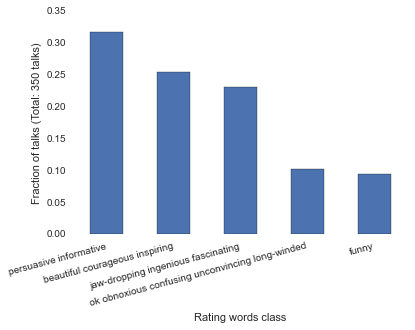

In [292]:
testfractions.plot(kind = 'bar')
plt.xticks(rotation = 15, ha = 'right')
plt.ylabel('Fraction of talks (Total: 350 talks)')
plt.xlabel('Rating words class')

###6.3 Get all test features into Xdftest

####6.3.1 features from talk  

In [293]:
Xdftest = finaltest[['id','themes','speaker_gender']]

####6.3.2 features from captions 

In [294]:
caps_test = pd.read_json('captions_test_f.json')[['id','length','num_para','word_per_sec','laughter_per_word','laugh_as_para',
                                     'applause_total','div_per_word','ithinks','storywords','noun_token','verb_token']]

In [295]:
caps_test.sort('id',inplace = True)

In [296]:
caps_test.reset_index(inplace = True, drop = True)

####6.3.3 features from other text 

In [297]:
Xtestother = pd.read_json('validset_other_text.json')

In [298]:
Xtestother.sort(columns = 'id',inplace = True)

In [299]:
Xtestother.reset_index(inplace = True, drop = True)

####6.3.4 merge all three soures

In [300]:
Xdftest = pd.merge(Xdftest, Xtestother, on = 'id')

In [301]:
Xdftest = pd.merge(Xdftest, caps_test, on = 'id')

In [302]:
Xdftest.sort(columns = 'id',inplace = True)

### 6.4 prepare y label 

In [303]:
testlabels.sort(columns = 'id',inplace = True)

In [304]:
testlabels.reset_index(drop = True, inplace = True)

In [305]:
testlabels[testlabels['id']==1146]['label']

168    2
Name: label, dtype: int64

In [306]:
yfinal = testlabels[['label']].values.flatten()

###6.5 Prediction 

In [307]:
Xth_test = Xdftest['themes'].as_matrix()

In [308]:
Xth_test = Cvtheme.transform(Xth_test)

In [309]:
Xtext_other_test = vect_other.transform(Xdftest['text'].as_matrix())

In [310]:
X_noun_test = tf_noun.transform(Xdftest['noun_token'].as_matrix())

In [311]:
X_verb_test = tf_verb.fit_transform(Xdftest['verb_token'].as_matrix())

In [312]:
oldcol = Xdftest.columns.tolist()

In [313]:
newcol = [u'id',u'themes',u'speaker_gender',u'length',u'num_para',u'word_per_sec',u'laughter_per_word',
 u'laugh_as_para',u'applause_total',u'div_per_word',u'ithinks',u'storywords',u'text',u'noun_token',u'verb_token']

In [314]:
Xdftest = Xdftest[newcol]

In [315]:
Xfinal = np.concatenate([Xth_test.toarray(),X_noun_test.toarray(), X_verb_test.toarray(),
                    Xtext_other_test.toarray(),scale(Xdftest.ix[:,2:12].as_matrix())],axis = 1)

In [316]:
Xfinal.shape

(350, 87)

####Prediction with SVM

In [317]:
yfinal_pred_svm = gs_svm.predict(Xfinal)

In [318]:
print classification_report(yfinal, yfinal_pred_svm)

             precision    recall  f1-score   support

          0       0.63      0.59      0.61       111
          1       0.58      0.47      0.52        89
          2       0.61      0.67      0.64        81
          3       0.29      0.42      0.34        36
          4       0.53      0.52      0.52        33

avg / total       0.57      0.55      0.56       350



In [319]:
pd.crosstab(yfinal_pred_svm,yfinal,rownames=['predicted'],colnames = ['true'],margins = True)

true,0,1,2,3,4,All
predicted,,,,,,
0,66,18,10,9,2,105
1,15,42,9,4,2,72
2,11,11,54,8,5,89
3,14,9,7,15,7,52
4,5,9,1,0,17,32
All,111,89,81,36,33,350


In [320]:
(66+42+54+15+17)/350.

0.5542857142857143

####Final prediction with Logistic regression 

In [321]:
yfinal_pred_logit = gs_logit.predict(Xfinal)

In [322]:
print classification_report(yfinal, yfinal_pred_logit)

             precision    recall  f1-score   support

          0       0.62      0.62      0.62       111
          1       0.56      0.47      0.51        89
          2       0.62      0.65      0.64        81
          3       0.33      0.36      0.34        36
          4       0.55      0.64      0.59        33

avg / total       0.57      0.57      0.57       350



###Plotting of prediction results 

####Confusion matrix and overall accuracy 

In [323]:
pd.crosstab(yfinal_pred_logit,yfinal,rownames=['predicted'],colnames = ['true'],margins = True)

true,0,1,2,3,4,All
predicted,,,,,,
0,69,19,12,11,1,112
1,17,42,8,5,3,75
2,12,10,53,7,3,85
3,8,7,7,13,5,40
4,5,11,1,0,21,38
All,111,89,81,36,33,350


In [324]:
print 'accuary is {:.2f}'.format((78+52+49+9+13)/350.)

accuary is 0.57


In [325]:
final_recall = pd.Series([0.62, 0.47, 0.65, 0.36, 0.64])

In [326]:
final_precision = pd.Series([0.62, 0.56, 0.62, 0.33, 0.55])

In [327]:
final_f1 = pd.Series([0.62, 0.51, 0.64, 0.34, 0.59])

In [328]:
tempdf = pd.DataFrame(dict(fractions = fractions.values,final_f1 = final_f1, final_recall = final_recall,
                          final_precision = final_precision))

In [329]:
tempdf = tempdf[['fractions','final_f1','final_recall','final_precision']]

In [330]:
tempdf.index = fractions.index

In [331]:
tempdf.columns= ['Label fractions','Prediction F1 scores','Prediction recall','Prediction precision']

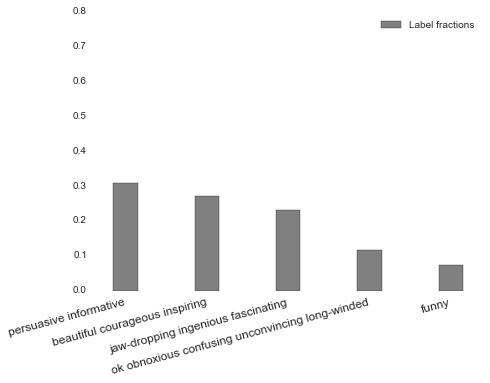

In [332]:
fig = plt.figure(figsize = (7,5))
ax3 = plt.gca()
tempdf['Label fractions'].plot(kind = 'bar',color = (0.5,0.5,0.5),ax = ax3,width = 0.3,left = [0,0.2,0.4,0.6])
plt.xticks(rotation = 15, ha = 'right',fontsize = 'large')
plt.ylim([0,0.8])
plt.legend(loc = 'upper right')

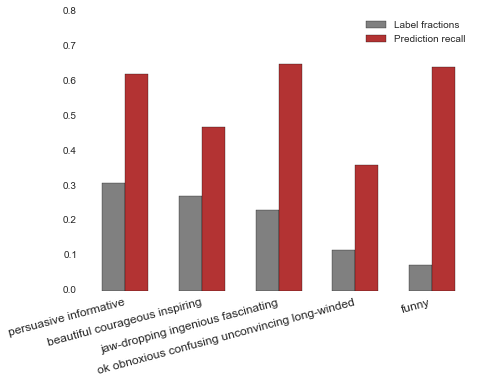

In [333]:
fig = plt.figure(figsize=(7,5))
ax3 = plt.gca()
tempdf[['Label fractions','Prediction recall']].plot(kind = 'bar',color = [(0.5,0.5,0.5),(0.7,0.2,0.2)]
                                                                           ,ax = ax3,width = 0.6,left = [0,0.2,0.4,0.6])
plt.xticks(rotation = 15, ha = 'right',fontsize = 'large')
plt.ylim([0,0.8])
plt.legend(loc = 'best')